1. Необходимые функции

In [68]:
import pandas as pd
import json


def read_file(file_name):
    return pd.read_csv(file_name, index_col=0)


def read_csv_in_chunks(file_name, column_names, need_column, chunksize=10000):
    df_list = []
    for chunk in pd.read_csv(file_name, usecols=lambda x: x in column_names, dtype=need_column, chunksize=chunksize):
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)


def get_memory_stat_by_column(df):
    memory_usage_stat = df.memory_usage(deep=True)
    total_memory_usage = memory_usage_stat.sum()
    print(f"file in memory size = {total_memory_usage // 1024:10} КБ")
    column_stat = list()
    for key in df.dtypes.keys():
        column_stat.append({
            "column_name": key,
            "memory_abs": memory_usage_stat[key] // 1024,
            "memory_per": round(memory_usage_stat[key] / total_memory_usage * 100, 4),
            "dtype": df.dtypes[key]
        })
    column_stat.sort(key=lambda x: x['memory_abs'], reverse=True)
    for column in column_stat:
        print(
            f"{column['column_name']:30}: {column['memory_abs']:10} КБ: {column['memory_per']:10}% : {column['dtype']}")


def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2
    return "{:03.2f} MB".format(usage_mb)


def opt_obj(df):
    converted_obj = pd.DataFrame()
    dataset_obj = df.select_dtypes(include=['object']).copy()

    for col in dataset_obj.columns:
        num_unique_values = len(dataset_obj[col].unique())
        num_total_values = len(dataset_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:, col] = dataset_obj[col].astype('category')
        else:
            converted_obj.loc[:, col] = dataset_obj[col]

    print(mem_usage(dataset_obj))
    print(mem_usage(converted_obj))
    return converted_obj


def opt_int(df):
    dataset_int = df.select_dtypes(include=['int'])
    converted_int = dataset_int.apply(pd.to_numeric, downcast='unsigned')
    print(mem_usage(dataset_int))
    print(mem_usage(converted_int))
    compare_ints = pd.concat([dataset_int.dtypes, converted_int.dtypes], axis=1)
    compare_ints.columns = ['before', 'after']
    compare_ints.apply(pd.Series.value_counts)
    print(compare_ints)

    return converted_int


def opt_float(df):
    dataset_float = df.select_dtypes(include=['float'])
    converted_float = dataset_float.apply(pd.to_numeric, downcast='float')

    print(mem_usage(dataset_float))
    print(mem_usage(converted_float))

    compare_floats = pd.concat([dataset_float.dtypes, converted_float.dtypes], axis=1)
    compare_floats.columns = ['before', 'after']
    compare_floats.apply(pd.Series.value_counts)
    print(compare_floats)

    return converted_float

In [69]:
# steps 1-3
file_name = "autos_sample.csv"
dataset = read_file(file_name)
get_memory_stat_by_column(dataset)

# steps 4-6
optimized_dataset = dataset.copy()

converted_obj = opt_obj(dataset)
converted_int = opt_int(dataset)
converted_float = opt_float(dataset)
#
optimized_dataset[converted_obj.columns] = converted_obj
optimized_dataset[converted_int.columns] = converted_int
optimized_dataset[converted_float.columns] = converted_float

# 7
get_memory_stat_by_column(dataset)
print(mem_usage(dataset))
print(mem_usage(optimized_dataset))
optimized_dataset.info(memory_usage='deep')

# 8
# отобрать свои 10 колонок
need_column = dict()
column_names = ['dateCrawled', 'name', 'seller',
                 'offerType', 'price', 'vehicleType',
                 'gearbox', 'powerPS', 'kilometer', 'brand']
opt_dtypes = optimized_dataset.dtypes
for key in column_names:
    need_column[key] = opt_dtypes[key]
    print(f"{key}:{opt_dtypes[key]}")

with open("dtypes_2.json", mode="w") as file:
    dtype_json = need_column.copy()
    for key in dtype_json.keys():
        dtype_json[key] = str(dtype_json[key])

    json.dump(dtype_json, file)
read_and_optimized = read_csv_in_chunks(file_name, column_names, need_column)

file in memory size =        913 КБ
name                          :         89 КБ:     9.8094% : object
dateCrawled                   :         74 КБ:     8.1225% : object
dateCreated                   :         74 КБ:     8.1225% : object
lastSeen                      :         74 КБ:     8.1225% : object
offerType                     :         62 КБ:       6.84% : object
brand                         :         62 КБ:     6.8205% : object
seller                        :         61 КБ:     6.7331% : object
abtest                        :         61 КБ:     6.6771% : object
gearbox                       :         60 КБ:     6.6709% : object
model                         :         59 КБ:     6.4699% : object
vehicleType                   :         58 КБ:     6.4479% : object
fuelType                      :         58 КБ:     6.4245% : object
notRepairedDamage             :         53 КБ:     5.8993% : object
price                         :          7 КБ:      0.855% : int64
yearOfRegistr

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [71]:
read_and_optimized

,dateCrawled,name,seller,offerType,price,vehicleType,gearbox,powerPS,kilometer,brand
0,2016-03-06 10:06:20,Sehr_sauber_vw_polo_Mit_klimaanlage,privat,Angebot,0,NaN,NaN,0,150000,volkswagen
1,2016-03-21 14:41:49,Opel_combo_1.7_D,privat,Angebot,450,andere,manuell,0,150000,opel
2,2016-03-16 07:56:19,FORD_KA___TÜV_ABGELAUFEN,privat,Angebot,250,NaN,NaN,60,150000,ford
3,2016-03-08 19:38:37,Mercedes_Benz_A_140_Classic_Klima_Scheckheft_D...,privat,Angebot,2990,limousine,automatik,82,70000,mercedes_benz
4,2016-03-09 14:52:30,BMW_525,privat,Angebot,11500,limousine,automatik,197,150000,bmw
...,...,...,...,...,...,...,...,...,...,...
995,2016-04-04 17:48:29,VW_Polo_Coupe_86c_in_rot__guter_Zustand__allta...,privat,Angebot,370,kleinwagen,manuell,54,125000,volkswagen
996,2016-03-31 22:58:15,Fast_Jang_Timer_sucht_Übernehmer_!!,privat,Angebot,1500,limousine,manuell,97,150000,mercedes_benz
997,2016-04-01 22:55:34,Audi_Cabriolet_Typ_89_2.0L,privat,Angebot,4800,cabrio,manuell,116,150000,audi
998,2016-03-23 19:00:20,Opel_Astra_2.0_16V_Turbo_Coupe,privat,Angebot,6999,coupe,manuell,265,150000,opel


<ipython-input-88-bae94bdb09f5>:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.gcf().autofmt_xdate()


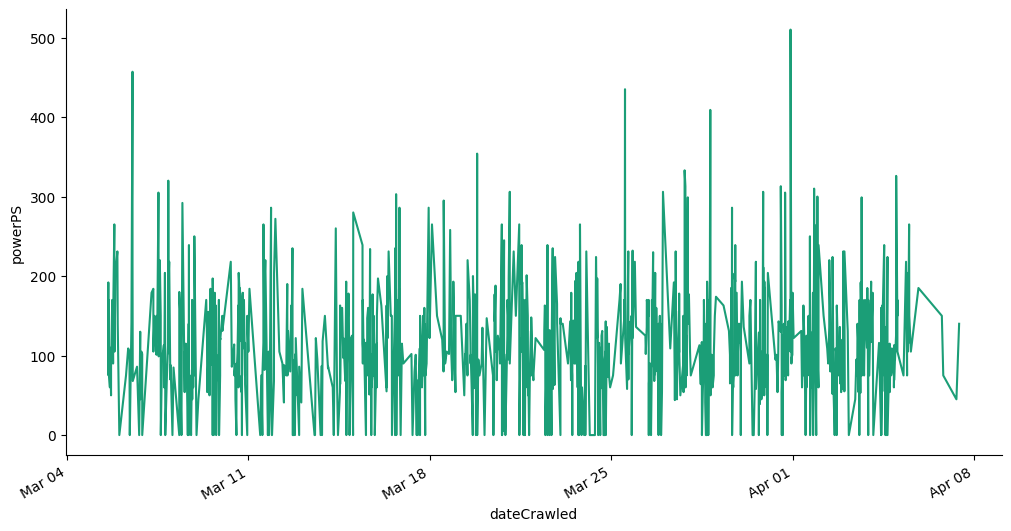

In [88]:
# @title dateCrawled vs powerPS

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dateCrawled']
  ys = series['powerPS']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = read_and_optimized.sort_values('dateCrawled', ascending=True)
df_sorted['dateCrawled'] = pd.to_datetime(df_sorted['dateCrawled'])
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dateCrawled')
_ = plt.ylabel('powerPS')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.gcf().autofmt_xdate()

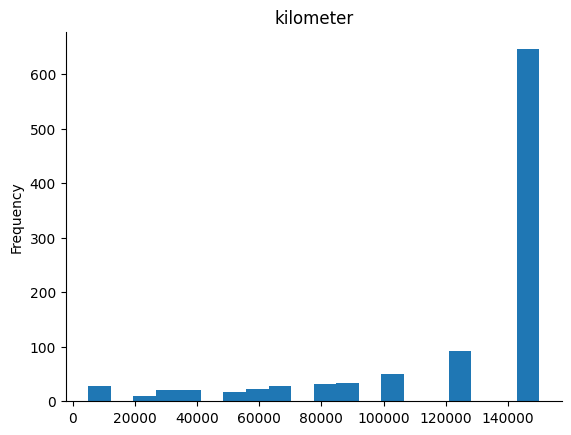

In [75]:
# @title kilometer

read_and_optimized['kilometer'].plot(kind='hist', bins=20, title='kilometer')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='powerPS', ylabel='kilometer'>

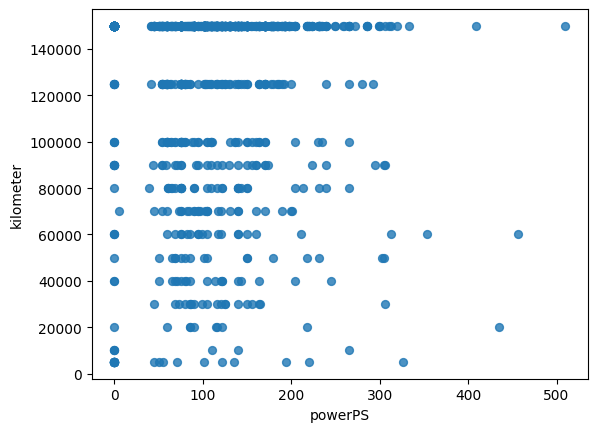

In [74]:
# @title powerPS vs kilometer

read_and_optimized.plot(kind='scatter', x='powerPS', y='kilometer', s=32, alpha=.8)
plt.gca()

<Axes: xlabel='kilometer', ylabel='brand'>

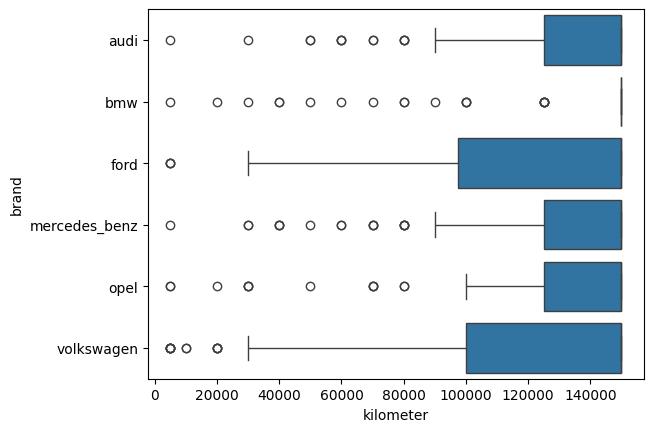

In [96]:
# @title brands-kilometers box-plots

brands_to_display = ['audi', 'bmw', 'ford', 'mercedes_benz', 'opel', 'volkswagen']  # Replace with your desired brands
sns.boxplot(data=read_and_optimized, x='kilometer', y='brand', order=brands_to_display)

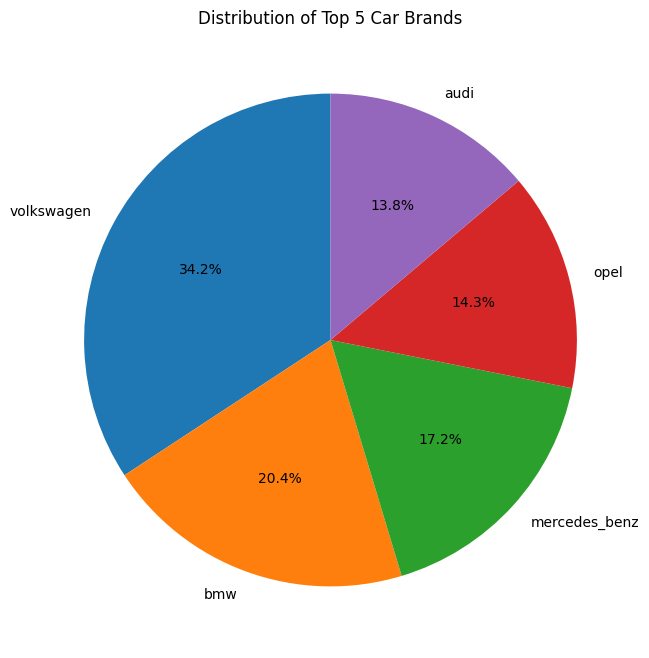

In [97]:
# @title circle brands diagram

brand_counts = read_and_optimized['brand'].value_counts()
top_brands = brand_counts.head(5)
plt.figure(figsize=(8, 8))
plt.pie(top_brands, labels=top_brands.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Top 5 Car Brands')
plt.show()

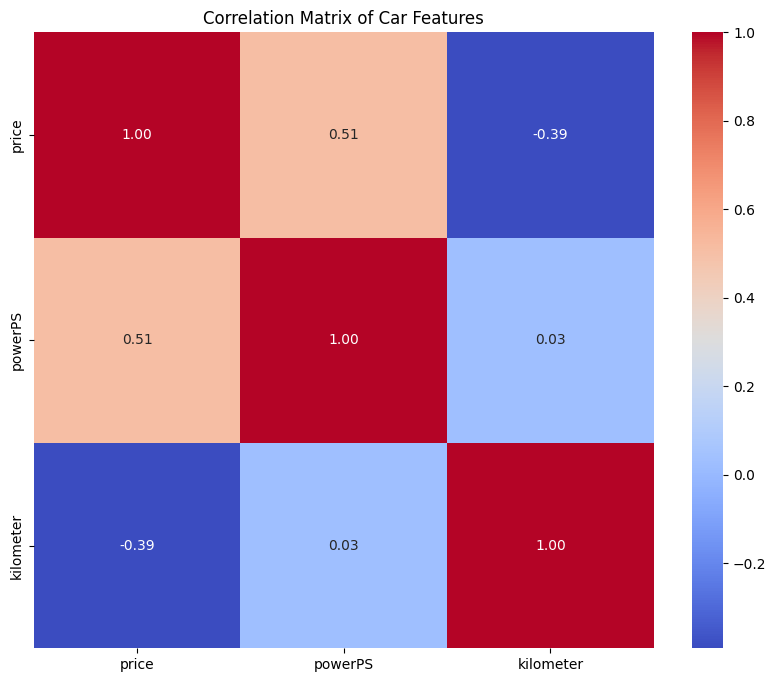

In [100]:
# @title correlation matrix

numerical_data = read_and_optimized.select_dtypes(include=['number'])
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Car Features')
plt.show()